In [67]:
import numpy as np
import imageio
import matplotlib
from scipy import ndimage as ndi
from matplotlib import pyplot as plt
%matplotlib notebook

In [68]:
bands = [imageio.imread('LC08_L1TP_191028_20181013_20181030_01_T1_B%d.TIF' % i)[3500:6500:2,2000:5000:2] + 0. for i in range(1,8)]

In [72]:
Nband = len(bands)
sh = bands[0].shape

# Convert the list of arrays into a 3D array (and cast to floats) 
bands = np.array(bands).astype(float)

# Replace the bad pixels with a median filter
threshold = 30
for i in range(Nband):
    df = ndi.median_filter(bands[i], 2) - bands[i]
    bands[i] += df*(abs(df)>threshold)

### 1. Training

In [73]:
# water
water = bands[:,930:1110, 400:1000] 

# forest
forest = bands[:, 525:757, 900:1100]

# field
field = bands[:, 150:300,150:300]

# city
city = bands[:, 950:975, 1165:1200]

samples = [water, forest, field, city]

In [78]:
rgb_img = np.empty(bands[0].shape + (3,), dtype=np.uint8)
rgb_img[:,:,0] = 255*(bands[3])/(bands[3].max())
rgb_img[:,:,1] = 255*(bands[2])/(bands[2].max())
rgb_img[:,:,2] = 255*(bands[1])/(bands[1].max())

<IPython.core.display.Javascript object>


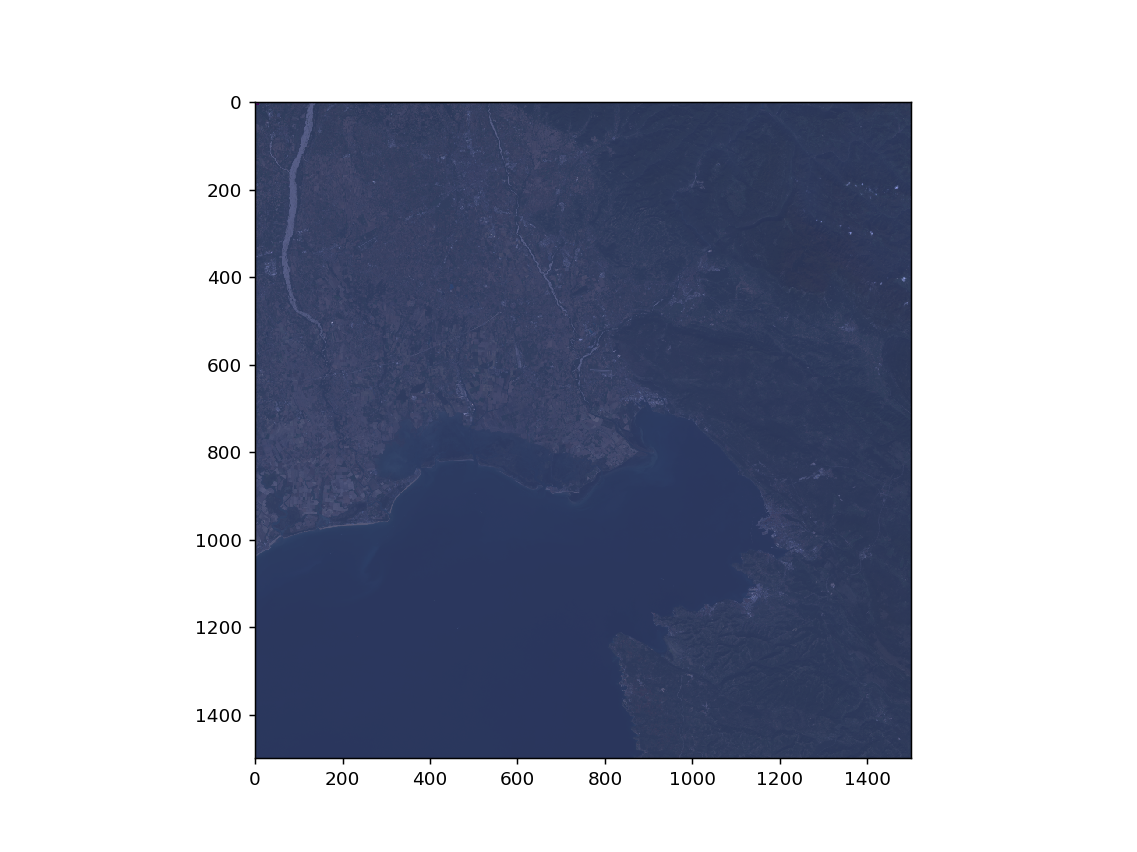

In [79]:
plt.imshow(rgb_img)

In [88]:
# Statistical characterisation of samples
"""
# BTW these are equivalent:

sample_mean = []
for b in bands:
    sample_mean.append(b.mean())

sample_mean = [b.mean() for b in bands]
"""
sample_mean = [s.mean(axis=-1).mean(axis=-1) for s in samples]
sample_cov = [np.cov(s.reshape((Nband, -1))) for s in samples]

sample_icov = [np.linalg.inv(c) for c in sample_cov]
sample_log_norm_C = [np.log(np.linalg.det(c)) for c in sample_cov]

### 2. Classification

In [102]:
def dist(x, mu, Cinv):
    """Compute 'Mahalanobis distance' """
    return ((x-mu) * np.dot(Cinv, x-mu)).sum(axis=0)

# Example: pixel (600,600)
x = bands[:, 600, 600:610]

# Water:
mu = sample_mean[0].reshape((Nband, 1))
Cinv = sample_icov[0]

# -log(likelihood function):
.5*(sample_log_norm_C[0] + dist(x, mu, Cinv))

array([306078.22522245, 404475.30353536, 333312.01105691, 255563.16682386,
       194394.809042  , 270313.78310668, 295739.08533882, 302012.35369647,
       181815.47246259, 138933.83083433])

In [103]:
# Ravel the pixels in the image 
pix = bands.reshape((Nband, -1))

# Compute the -log likelihood for each class
di = [dist(pix, sample_mean[i].reshape((Nband, 1)), sample_icov[i]) + sample_log_norm_C[i] for i in range(len(samples))]

In [104]:
di = np.array(di)

In [ ]:
di.resize((len(samples),) + sh)

In [107]:
di[:,600,600]

array([6.12156450e+05, 1.13982496e+02, 1.21076054e+02, 9.03986111e+01])

In [108]:
class_index = di.argmin(axis=0)

In [109]:
class_index.shape

(1500, 1500)

<IPython.core.display.Javascript object>


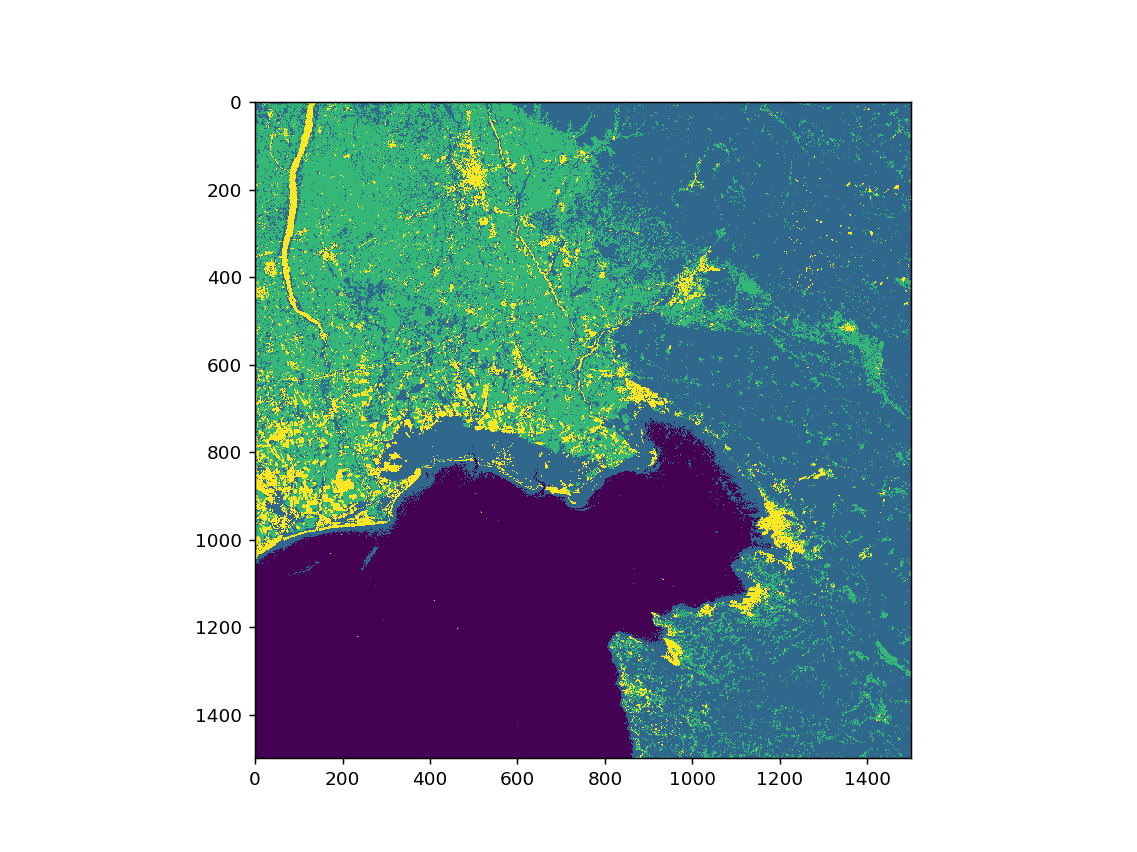

In [111]:
plt.figure()
plt.imshow(class_index)